### Data Science Challenge
#### Author: Pablo Felgueres
#### July 19th, 2017
#### Description: Predict shopping time in store.
#### Notebook Description:
Run model to predict shopping time using the generated code in the challenge.

Folder structure:  
.  
\+ /data/
  
>  \+ order_items.csv  
   \+ test_trips.csv  
   \+ train_trips.csv  
  
\+ /notebooks/
>  \+ 01_PF_Initial_EDA.ipynb  
>  \+ 02_PF_Modeling.ipynb **(You are here)**

\+ /src/
>  \+ model.py  
>  \+ preprocessing.py  
>  \+ split4validation.py

#### General file usage: 

There are 3 .py files:  
  
1) model.py: Includes the model to predict shopping time - similar to this file.
  
2) preprocessing.py: Includes the Preprocessing class which should be used prior to running the model --> Serves the purpose of an organized pipeline.  
  
3) split4validation.py: Script to split the training dataset into training-validation. This serves to evaluate the model with an outofsample to avoid overfitting. 

#### Modeling initial notes: 

- From the EDA, it seems there is linearity in the data. The most natural model would be to do a linear regression as baseline and work from there.  
  
  
- Having information about the basket to be predicted assumes that for all future predictions there will be information from the actual purchase.  
  
  This doesn't make a lot of sense if this model serves the purpose of predicting future times. 
  
  However, a model like this would be useful for inference; understand the drivers of shopping times.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
import sys
sys.path.append('../src/')
from preprocessing import Preprocess
from split4validation import split
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error
import seaborn as sns
from sklearn.linear_model import Lasso
sns.set_style('white')
%matplotlib inline

Go to the preprocess.py file to see the code on how to handle dummy variables and scaling while avoiding data leakage. 

In [3]:
#Split train into train-validation.
data_train_order, data_train_trips, data_val_order, data_val_trips = split('../data/')

#Preprocess data with the fit method.
train = Preprocess(data_train_order, data_train_trips, train =True)
train.fit()

#Preprocess validation data
val = Preprocess(data_val_order, data_val_trips, train =True)
val.fit()

#Get data
X_train, y_train = train.get_traindata()
X_val, y_val = val.get_traindata()

y_train = y_train.values
y_val = y_val.values

### Baseline

In [61]:
#As baseline I'll use the mean as predictor first. 
y_means = np.ones_like(y_val) * y_val.mean()
print 'The MSE for mean model is {0: ,}'.format(mean_squared_error(y_val, y_means))
print 'The MAE for mean model is {0: ,}'.format(mean_absolute_error(y_val, y_means))
print 'Should be zero -----> {0: .1%}'.format(r2_score(y_val, y_means))

The MSE for mean model is  2,164,660.45553
The MAE for mean model is  1,123.21667077
Should be zero ----->  0.0%


### Linear Regression

In [62]:
#To avoid rerunning the last snippet - do not reet X_train, y_train, X_val, y_val. Use other names.
X_train_features = X_train
X_val_features = X_val

#Add an intercept for the regression
X_train_features['intercept'] = 1
X_val_features['intercept'] = 1

#Get vectors
X_train_features = X_train_features
X_val_features = X_val_features

lin_model = sm.OLS(y_train, X_train_features, hasconst=True).fit()
lin_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
======================================================================
Model:               OLS              Adj. R-squared:     0.307       
Dependent Variable:  y                AIC:                1829819.2395
Date:                2017-07-24 21:41 BIC:                1830049.3296
No. Observations:    107698           Log-Likelihood:     -9.1489e+05 
Df Model:            23               F-statistic:        2080.       
Df Residuals:        107674           Prob (F-statistic): 0.00        
R-squared:           0.308            Scale:              1.4003e+06  
----------------------------------------------------------------------
                 Coef.   Std.Err.    t     P>|t|    [0.025     0.975] 
----------------------------------------------------------------------
basket_volume     8.2786   0.9993   8.2847 0.0000     6.3201   10.2372
item_cnt         39.3595   0.4910  80.1688 0.0000    38.3973   40.3218
dpts_cnt         96.9593   1.8676  51.9159 0.0000    93.2988  100.6198
reorder_factor -365.4093  11.5980 -31.5062 0.0000  -388.1412 -342.6773
is_busy         116.1500   7.8027  14.8858 0.0000   100.8567  131.4432
(11.0, 15.0]     49.1055   8.8186   5.5684 0.0000    31.8211   66.3899
(15.0, 19.0]     56.2305   9.3601   6.0075 0.0000    37.8849   74.5761
(19.0, 23.0]   -193.9044  21.0712  -9.2024 0.0000  -235.2036 -152.6052
(9.5, 10.0]     -42.1225   8.1592  -5.1626 0.0000   -58.1144  -26.1306
(10.0, 10.5]      0.0000   0.0000   7.6334 0.0000     0.0000    0.0000
(10.5, 11.0]    -31.9566   9.9826  -3.2012 0.0014   -51.5224  -12.3908
3               321.4134   9.9061  32.4459 0.0000   301.9975  340.8292
5               107.6787  13.5761   7.9315 0.0000    81.0698  134.2876
6               242.7271  23.0234  10.5426 0.0000   197.6017  287.8526
29             -376.2053  18.7664 -20.0467 0.0000  -412.9873 -339.4233
31             -115.3770  16.6869  -6.9142 0.0000  -148.0831  -82.6709
54             -759.4731  53.3690 -14.2306 0.0000  -864.0756 -654.8707
78             -392.3871 103.3119  -3.7981 0.0001  -594.8770 -189.8973
90             -369.8295  40.6623  -9.0952 0.0000  -449.5270 -290.1320
105            -273.1665  19.5998 -13.9372 0.0000  -311.5819 -234.7511
115            -182.2285  22.6389  -8.0493 0.0000  -226.6005 -137.8565
123            -127.8072  32.9772  -3.8756 0.0001  -192.4419  -63.1724
126             100.9899  28.7535   3.5123 0.0004    44.6335  157.3463
148            -770.1014 185.0938  -4.1606 0.0000 -1132.8826 -407.3201
intercept      1557.5363  19.5994  79.4685 0.0000  1519.1217 1595.9509
----------------------------------------------------------------------
Omnibus:         23324.100   Durbin-Watson:      1.951                
Prob(Omnibus):   0.000       Jarque-Bera (JB):   79099.328            
Skew:            1.084       Prob(JB):           0.000                
Kurtosis:        6.595       Condition No.:      145185269261062619136
======================================================================
* The condition number is large (1e+20). This might indicate
strong multicollinearity or other numerical problems.
"""

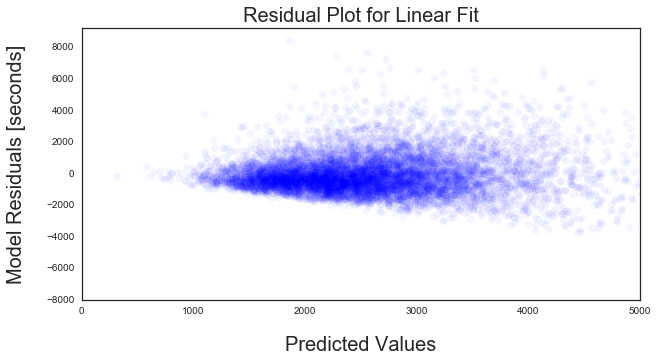

In [68]:
#Plotting the residuals against the fitted values to spot a non-linear trend.
y_pred = lin_model.predict(X_val_features)
residuals = y_val.flatten() - y_pred

#Create figure
figure = plt.figure(figsize=(10,5))
ax = figure.add_subplot(111)
ax.scatter(y_pred, residuals, alpha = 0.04, c= 'blue')
ax.set_ylabel('Model Residuals [seconds]', fontsize = 20, labelpad = 20)
ax.set_xlabel('Predicted Values', fontsize = 20, labelpad = 20)
ax.set_xlim(0,5000)
plt.title('Residual Plot for Linear Fit', fontsize = 20)

The variances of the error increase with the value of the response! This is also called hetereoscedasticity. 
A nice way to deal with this problem is to transform the reponse variable using a concave function to shrink the larger values of Y. 

I'll try doing a log transformation log(Y), the sqrt(Y) is possible as well.  
  
It seems that the variance increases past the 3000 s mark. Two set of models 1) < 3000s, 2) >3000s could be explored.

### Linear Regression - 2nd Iteration - Sqrt Transform (Y)

In [64]:
#Get vectors
y_train_sqrt = np.sqrt(y_train)
y_val_sqrt = np.sqrt(y_val)

#Training the model
model_lin_log = sm.OLS(y_train_sqrt, X_train_features, hasconst=True).fit()

#Show summary of results
model_lin_log.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.325      
Dependent Variable: y                AIC:                827771.6169
Date:               2017-07-24 21:41 BIC:                828001.7070
No. Observations:   107698           Log-Likelihood:     -4.1386e+05
Df Model:           23               F-statistic:        2254.      
Df Residuals:       107674           Prob (F-statistic): 0.00       
R-squared:          0.325            Scale:              127.48     
--------------------------------------------------------------------
                  Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
--------------------------------------------------------------------
basket_volume      0.0762   0.0095   7.9889 0.0000   0.0575   0.0949
item_cnt           0.3354   0.0047  71.6040 0.0000   0.3262   0.3446
dpts_cnt           1.1659   0.0178  65.4266 0.0000   1.1310   1.2008
reorder_factor    -3.6019   0.1107 -32.5494 0.0000  -3.8188  -3.3851
is_busy            1.1328   0.0744  15.2162 0.0000   0.9869   1.2787
(11.0, 15.0]       0.4759   0.0841   5.6560 0.0000   0.3110   0.6408
(15.0, 19.0]       0.6450   0.0893   7.2219 0.0000   0.4699   0.8200
(19.0, 23.0]      -1.9477   0.2010  -9.6876 0.0000  -2.3417  -1.5536
(9.5, 10.0]       -0.3472   0.0778  -4.4596 0.0000  -0.4998  -0.1946
(10.0, 10.5]       0.0000   0.0000  14.1327 0.0000   0.0000   0.0000
(10.5, 11.0]      -0.0723   0.0952  -0.7590 0.4479  -0.2590   0.1144
3                  3.0728   0.0945  32.5104 0.0000   2.8876   3.2581
5                  1.5568   0.1295  12.0185 0.0000   1.3029   1.8107
6                  2.3818   0.2197  10.8424 0.0000   1.9512   2.8124
29                -4.2471   0.1791 -23.7194 0.0000  -4.5981  -3.8962
31                -1.0619   0.1592  -6.6696 0.0000  -1.3740  -0.7498
54                -8.5455   0.5092 -16.7818 0.0000  -9.5436  -7.5475
78                -3.8694   0.9857  -3.9254 0.0001  -5.8014  -1.9374
90                -4.9534   0.3880 -12.7674 0.0000  -5.7138  -4.1930
105               -2.7960   0.1870 -14.9510 0.0000  -3.1625  -2.4294
115               -1.9625   0.2160  -9.0852 0.0000  -2.3858  -1.5391
123               -1.0643   0.3146  -3.3825 0.0007  -1.6810  -0.4476
126                0.8355   0.2743   3.0452 0.0023   0.2977   1.3732
148              -14.2685   1.7660  -8.0794 0.0000 -17.7300 -10.8071
intercept         38.1361   0.1870 203.9306 0.0000  37.7696  38.5026
--------------------------------------------------------------------
Omnibus:          3853.502  Durbin-Watson:     1.952                
Prob(Omnibus):    0.000     Jarque-Bera (JB):  6829.252             
Skew:             0.300     Prob(JB):          0.000                
Kurtosis:         4.078     Condition No.:     145185269261062619136
====================================================================
* The condition number is large (1e+20). This might indicate
strong multicollinearity or other numerical problems.
"""

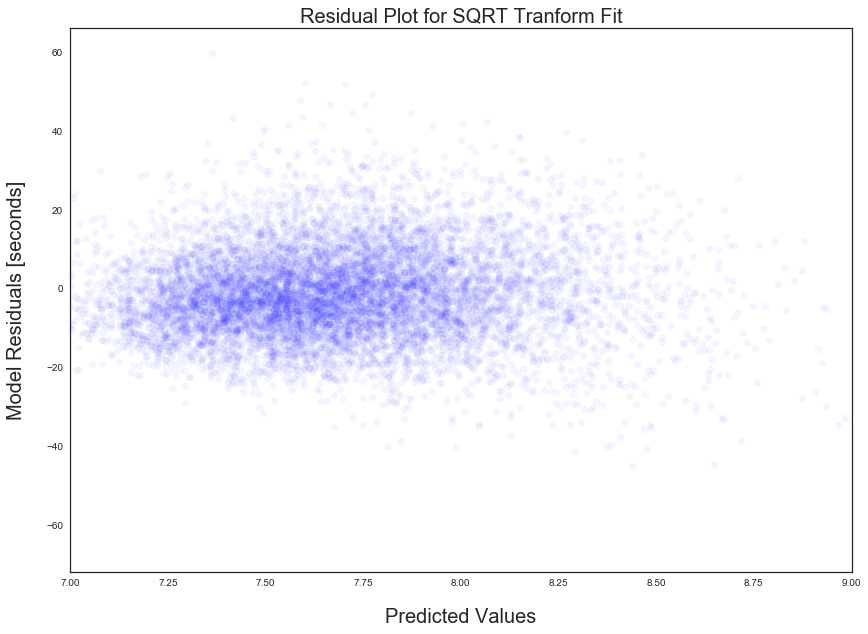

In [69]:
#Predict
y_pred = model_lin_log.predict(X_val_features)

residuals_log = y_val_sqrt.flatten() - y_pred

#We can also plot for the residuals against the fitted values to spot a non-linear trend.
figure = plt.figure(figsize=(14,10))
ax = figure.add_subplot(111)

ax.scatter(y_pred_lin_log, residuals_log, alpha = 0.04, c= 'blue')

ax.set_ylabel('Model Residuals [seconds]', fontsize = 20, labelpad =20)
ax.set_xlabel('Predicted Values', fontsize = 20, labelpad = 20)
ax.set_xlim(7,9)

plt.title('Residual Plot for SQRT Tranform Fit', fontsize = 20)

The cone shape has been removed with the log transform! 
The model also showed improvement.

In [70]:
print 'The MSE for the linear regression is {0: ,}'.format(mean_squared_error(y_val, y_pred**2))

The MSE for the linear regression is  1,528,542.66909


In [71]:
print 'The MAE for the log(Y) linear regression is {0: ,}'.format(mean_absolute_error(y_val, y_pred**2))

The MAE for the log(Y) linear regression is  887.754135995


Using the MAE as reference, the sqrt transform of Y provides a slightly better model.  
  
This also means our model might be performing poorly on points of high leverage.

### Linear Regression - 3rd Iteration - Scaling predictors

In [78]:
#Leave categorical out, scale and merge
X_train_scaled = X_train
X_val_scaled = X_val 

X_train_only_continous = X_train_scaled.iloc[:,:4]
X_train_only_continous = StandardScaler().fit_transform(X_train_only_continous)

X_train_scaled = pd.concat([X_train_scaled.iloc[:,4:], pd.DataFrame(X_train_only_continous, columns= X_train_scaled.columns[:4])], axis =1)

#Validation Dataset
X_val_only_continous = X_val_scaled.iloc[:,:4]
X_val_only_continous = StandardScaler().fit_transform(X_val_only_continous)

X_val_scaled = pd.concat([X_val_scaled.iloc[:,4:], pd.DataFrame(X_val_only_continous)], axis =1)

In [79]:
#Scaled model
model_lin_log_scaled = sm.OLS(y_train_sqrt, X_train_scaled, hasconst=False).fit()

#Show summary of results
print model_lin_log_scaled.summary2()

print '-------------------------------'

y_pred = model_lin_log_scaled.predict(X_val_scaled)

print 'The MSE for the scaled model is: {0:}'.format(mean_absolute_error(y_val, y_pred**2))


                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.325      
Dependent Variable: y                AIC:                827771.6169
Date:               2017-07-24 21:46 BIC:                828001.7070
No. Observations:   107698           Log-Likelihood:     -4.1386e+05
Df Model:           23               F-statistic:        2254.      
Df Residuals:       107674           Prob (F-statistic): 0.00       
R-squared:          0.325            Scale:              127.48     
--------------------------------------------------------------------
                  Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
--------------------------------------------------------------------
is_busy            1.1328   0.0744  15.2162 0.0000   0.9869   1.2787
(11.0, 15.0]       0.4759   0.0841   5.6560 0.0000   0.3110   0.6408
(15.0, 19.0]       0.6450   0.0893   7.2219 0.0000   0.4699   0.8200
(19.0, 23.0]      -1.9477   0.2010  -9.6876 0.0000  

We got a slight gain by scaling as well.

Let's try to find out whether we can eliminate some of the coefficients and navigate the bias variance trade-off.

### Linear Regression - 4th Iteration - Lasso Regression

In [82]:
#Leave categorical out, scale and merge
X_train_scaled = X_train
X_val_scaled = X_val 

X_train_only_continous = X_train_scaled.iloc[:,:4]
X_train_only_continous = StandardScaler().fit_transform(X_train_only_continous)

X_train_scaled = pd.concat([X_train_scaled.iloc[:,4:], pd.DataFrame(X_train_only_continous, columns= X_train_scaled.columns[:4])], axis =1)

#Validation Dataset
X_val_only_continous = X_val_scaled.iloc[:,:4]
X_val_only_continous = StandardScaler().fit_transform(X_val_only_continous)

X_val_scaled = pd.concat([X_val_scaled.iloc[:,4:], pd.DataFrame(X_val_only_continous)], axis =1)

#Training the model
model = Lasso().fit(X_train_scaled, y_train_sqrt)
y_pred_lasso = lin_model.predict(X_val_scaled)
print 'The MSE for untuned Lasso is {0: ,}'.format(mean_squared_error(y_val, y_pred_lasso))
print 'The MAE for untuned Lasso is {0: ,}'.format(mean_absolute_error(y_val, y_pred_lasso))

The MSE for untuned Lasso is  8,075,347.30252
The MAE for untuned Lasso is  2,433.25998325


With the alpha as it is, were are probably driving the coefficients to zero, let's take a look.

In [83]:
model.coef_

array([ 0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  3.32802389,  3.41537977, -0.        ])

So we are indeed driving them to zero, meaning our alpha is overpenalizing all coefficients as it is.  
  
I'll cross validate on a range of alphas to find the best option.

In [96]:
def model_cv(clf, X, y):
    '''
    Helper function to cross-validate a model.
    '''
    error = -1 * np.mean(cross_val_score(clf, X, y, scoring = 'neg_mean_squared_error', cv=5))
        
    return error

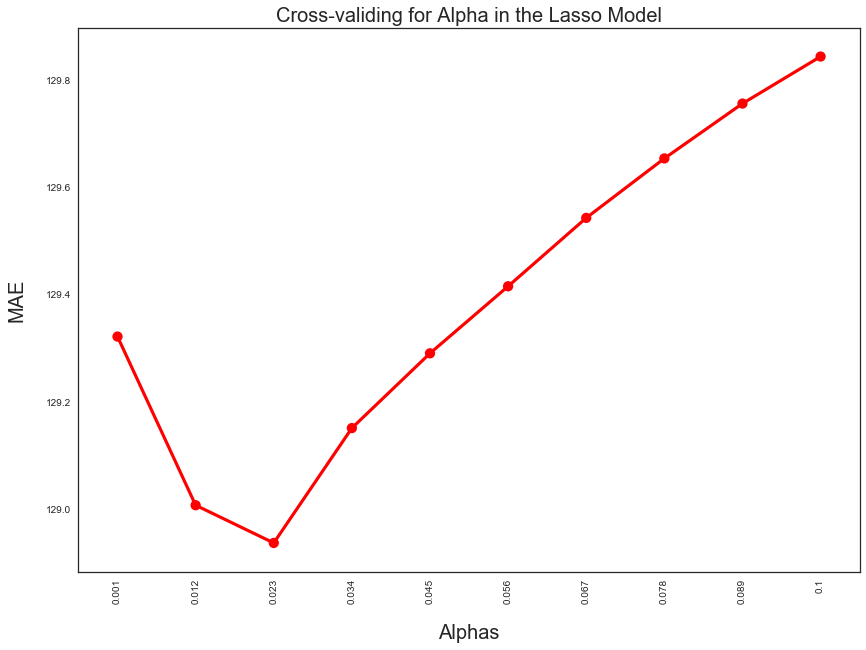

In [101]:
#Let's cross-validate for different alphas
alphas = np.linspace(0.001, 0.1, 10)

mse_alphas = []

for a in alphas:
    model_lasso = Lasso(alpha = a)
    mse_alphas.append(model_cv(model_lasso, X_train_scaled, y_train_sqrt))
    
plt.figure(figsize=(14,10))
sns.pointplot(alphas, mse_alphas, color = 'red')
plt.ylabel('MAE', fontsize=20, labelpad =20)
plt.xlabel('Alphas', fontsize=20, labelpad = 20)
plt.title("Cross-validing for Alpha in the Lasso Model", fontsize=20)
plt.xticks(rotation='vertical')
plt.show()

Beautiful, it seems the best alpha is around 0.023

Let's check on the coefficients:

In [102]:
#Let's cross-validate for different alphas
coeff_alphas = []

for a in alphas:
    model_lasso = Lasso(alpha = a).fit(X_train_scaled, y_train_sqrt)
    coeff_alphas.append((model_lasso.coef_))

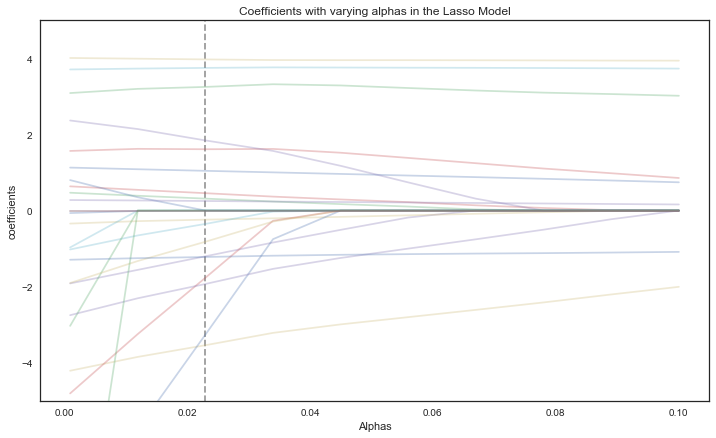

In [115]:
fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(111)
ax.plot(alphas, coeff_alphas, alpha = 0.3)
ax.vlines(x = 0.023, ymin = -6, ymax=6, alpha = 0.4, linestyles='--')
ax.set_ylim(-5, 5)
ax.set_ylabel('coefficients')
ax.set_xlabel('Alphas')
plt.title('Coefficients with varying alphas in the Lasso Model')

We could now take a look into which features where driven to zero from the cross-validated alpha and obtain insights on the effect of features to shopping duration!

In [116]:
model_lasso = Lasso(alpha = 0.023).fit(X_train_scaled, y_train_sqrt)

In [128]:
coeff = pd.DataFrame(np.dstack((model_lasso.coef_, X_train_scaled.columns))[0]).set_index(1).rename(columns = {0: 'Coeff'})

del coeff.index.name

In [171]:
eliminated_coeff = coeff.Coeff == 0

In [175]:
coeff[eliminated_coeff].index

Index([(10.0, 10.5], (10.5, 11.0], 78, 123, 126, 148, u'intercept'], dtype='object')

A few story IDs and hour of the day buckets where removed. 

In [194]:
coeff['abs'] = np.absolute(coeff.Coeff)
top10 = coeff.sort_values('abs', ascending = False).iloc[:10].reset_index()

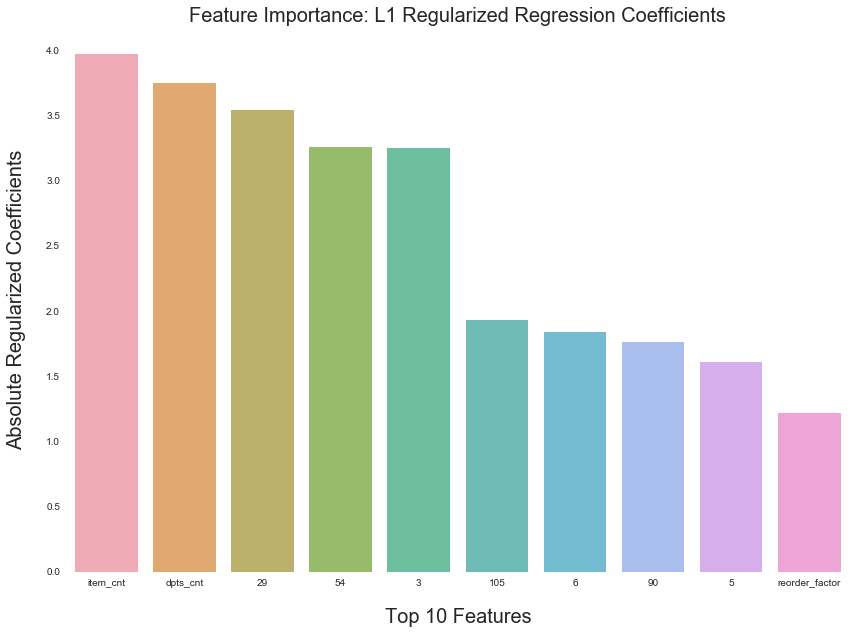

In [196]:
fig = plt.figure(figsize=(14,10))
ax_ = fig.add_subplot(111)
sns.barplot(x = 'index', y = 'abs', data = top10, alpha=0.8, ax = ax_)
ax_.set_ylabel('Absolute Regularized Coefficients', fontsize=20, labelpad=20)
ax_.set_xlabel('Top 10 Features', fontsize=20, labelpad=20)
plt.title('Feature Importance: L1 Regularized Regression Coefficients', fontsize = 20)
sns.despine(left=True, bottom=True)

Nice! We can now know what it is the size of the effect for each feature agains shopping time!  
It looks like item count, department count, few store ID and the reorder factor are the most relevant features of our current model. 

In [198]:
#Finally this model score is:
y_pred_lasso = model_lasso.predict(X_val_scaled)

print 'The MAE for tuned Lasso is {0: ,}'.format(mean_absolute_error(y_val, y_pred_lasso ** 2))

The MAE for tuned Lasso is  879.454486857


Note this model is slightly worse than the previously fitted regression.  
  
However, this model has been crossvalidated and should perform with lower variance against an unseen dataset. 

### Non-linear modeling: Random Forest

A Random Forest might be well suited for this scenario as well, and out of curiosity I'll explore the performance of it.

In [203]:
#Out of the box RF
rf = RandomForestRegressor(n_estimators = 100, max_features = 'sqrt')

#Train - predict 
rf.fit(X_train_scaled, y_train_sqrt)
y_pred_rf = rf.predict(X_val_scaled)

print 'MAE for an outofbox RandomForest is: {0:}'.format(mean_absolute_error(y_val, y_pred_rf **2))

MAE for an outofbox RandomForest is: 850.592887997


So after all the work on the Lasso, it turns out a Random Forest outperforms outperforms it but still, each has it's advantages.

Depending on our goal for this model, these are some considerations to take into account going forward from here.

Random Forest: 
- Can be parallelized so fitting larger sized datasets is not a problem
- Fast predections once it has been trained

Considerations: 
- We can take a look at a relative metric of feature importance to gauge their importance agains shopping duration. Still it is not as interpretable as the Lasso counterpart. 
- Needs to be tuned. Naturally we could increase the number of estimators and vary the number of maximum random features per split. I would use cross-validation to pick on the parameters that decrease the error metric.
- We could try a boosted variation of the tree-based model.


Lasso

Pros:
- Since it is a linear model, we can provide measurable insight on how our features influence shopping duration, providng extra value for teams to guide optimizations.
- It is not parallizable yet it doesn't require great computational challenges.
- This model could be updated online as more data becomes available using stochastic gradient descent, instead of batch processing.

Considerations:
- As we saw from plotting and the MSE, there are high infulential points to be addressed before fitting the model. - We should explore increasing the complexity of this model, while cross-validating to avoid overfitting. Ideas would be to create cross-effects between our continous variables and some variable transformations (squared, cubed).


In any case, I would spent more time developing the feature space -- since better features typically beat better models.